# Carcou, Your Personalised Career Bot

brought to you by `Shami THIRION SEN`

---

We know how grueling a job hunt can be! Work is not only the means of earning our living, but most importantly, it is a way of unleashing our inner talents.

Worry no more! Your virtual counsellor is at your service to guide you through this process, whether you’re a newbie trying to make your way into the job market, or an experienced professional looking to expand your horizons! We have got you covered!

---

### 🧠 Agentic AI

Welcome to our **Agentic AI** showcase!  
This project features a **virtual counselor** designed to interact with users, gather relevant information, and fetch contextually useful answers from the internet 🌐.

It demonstrates our ability to build intelligent, interactive, and autonomous AI experiences.

---


---

### 📦 Installing the Libraries

Let’s get the formalities out of the way 🛠️  
In this section, we’ll **install the necessary dependencies and the google API Key** (and clean out any that aren’t needed).

Additional libraries will be imported as we move through the notebook and explore different sections. Stay tuned 📚

---


In [4]:
!pip uninstall -qqy jupyterlab kfp 2>/dev/null  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0" "chromadb==0.6.3"
!pip uninstall -y async-timeout # Uninstall the conflicting version of async-timeout
!pip install "async-timeout>=4.0.0,<5.0.0" # Install a compatible version of async-timeout within the required range
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai # Removing potentially conflicting packages
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' # Install langgraph and related packages

from google import genai
from google.genai import types
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
client = genai.Client(api_key=GOOGLE_API_KEY)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 16.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 67.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

---

### 🔁 Adding Retry Logic

To make our AI agent more **robust and reliable**, we add a retry mechanism to handle occasional API hiccups (like rate limits or temporary outages).

Using `google.api_core.retry`, we wrap the `generate_content` function so that it **automatically retries** when specific error codes (`429`, `503`) are encountered.

This helps avoid crashes during high-traffic times or flaky network issues 🚦

---


In [5]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

---

### 🤖 Creating the Chat Agent

Time to build our **virtual career counsellor**, `CarCou` — a smart, structured, and encouraging AI designed to help users explore and grow their careers 🌱.

#### 🧱 State Definition

We define a `SearchState` to manage the conversation:
- `messages`: Tracks the ongoing dialogue, updated via `add_messages`
- `finished`: A flag indicating if the user's journey is complete

This setup ensures that our chatbot can **retain conversation context** across each interaction.

#### 🧠 System Instructions

We provide CarCou with clear behavioral guidelines:
- Start by introducing itself
- Collect user info step-by-step: name, education, experience level, goals
- Ask clarifying questions if needed
- Suggest 3 job roles tailored to the user
- Offer to generate a résumé and cover letter (in Markdown) ✨
- End politely if the user types `q` or `exit`

> 💬 All messages are designed to be concise, well-structured, and easy to follow.

#### 👋 Welcome Message

The chat begins with an inviting prompt that asks the user about their intent:
```text
Welcome! I am CarCou, your virtual Career Counsellor...


In [6]:
# Creating Chat Agent

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# State is a Dict with messages, conversation status, finished keys
class SearchState(TypedDict):
    """State representing the conversation status."""

    # The chat conversation. Preserves the conversation history between nodes. 
    # The `add_messages` annotation indicates to LangGraph that state is updated by appending returned messages, not replacing them.
    messages: Annotated[list, add_messages]    
    finished: bool # Flag indicating that the order is placed and completed.


# System instruction defining how the chatbot is expected to behave (rules, functions and tones)
CAREERCOUNSELLORBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a Career Counsellor Bot named CarCou, an interactive all comprehensive career counsellor facilitating professional evolution of beginner to advanced job seekers and help keep morales high."
    "Always present the information in a structured manner, enumerate when suitable. Don't display long lines of text. 10 words are ideal."
    "First present yourself as CarCou a reliable career counsellor here to help the person get their dream job."
    "Then ask the user about themselves: their name, current degrees, professional interests (particular sector), and their experience level, beginner : entering the job market, experienced : looking for a change, established: looking to further career prospects. Ask the questions one by one."
    "Ask clarifying questions if any of the answers are vague or don't provide precise information."
    "Ask for all the information one by one, memorise them and confirm the information at the end."
    "Suggest 3 most suitable jobs for the person. Call store_jobs to store the 3 jobs you suggest as string values, in this way store_jobs(job1, job2, job3)."
    "Ask them which one is their favourite option. And ask them if they would live help with a tailored résume.If the user says yes, generate a cv for that position in a markdown format based on the information collected. Else skip to the next question."
    "Then ask if they need help with a cover letter. If they say yes, ask for more details like name, surname and address and please generate a letter in a markdown format."
    "Else say thank you and ask them to continue down the page to get more valuable information, exit the chat."
    "If at any point the user types 'q' or 'exit', end the chat",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome ! I am CarCou your virtual Career Counsellor. I am here to help you unlock your potentials. Are you here today : i) for a job hunt ii)to improve your current prospects eg. salary or change of position ? iii) Please Type `q` to quit."

---

### Defining the Chatbot Logic

We now define **CarCou's conversational flow** by combining the power of **LangGraph** and **Gemini 2.0 Flash** ✨.

#### ⚙️ Language Model Setup

We initialize the chatbot using:

```python
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
```

This allows us to invoke messages with Google's lightweight yet powerful language model.

---

#### 💬 Chatbot Function

The `chatbot()` function acts as a **wrapper** around the language model's chat interface:
- It maintains message history
- It includes the system prompt to guide tone & logic
- It returns the model's response as an updated state

---

#### 👤 Human Interaction Node

The `human_node()` handles:
- Displaying the last message from the bot
- Capturing the user's input
- Flagging when the user chooses to exit (e.g., typing `q`, `exit`, or just pressing Enter)

This function keeps the interaction simple and intuitive.

---

#### 👋 Chatbot with a Friendly Welcome

The `chatbot_with_welcome_msg()` function starts the chat gracefully:
- If no messages are present, it sends the `WELCOME_MSG`
- Otherwise, it proceeds with the conversation

> 🪄 This gives users a smooth, welcoming first impression while keeping responses structured.

---

#### 🔁 Routing the Flow

Finally, `maybe_exit_human_node()` decides whether the chat should continue or end:
- If the conversation is marked as `finished`, we route to `END`
- Otherwise, we loop back to the chatbot

This setup helps CarCou gracefully end sessions when needed 💼

---


In [7]:
## Defining Chatbot

from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display
from langchain_core.messages.ai import AIMessage
from typing import Literal



# Picking gemini 2.0 flash model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot(state: SearchState) -> SearchState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [CAREERCOUNSELLORBOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}

## Defining the human node
def human_node(state: SearchState) -> SearchState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)
    user_input = input("User: ")
    # If it looks like the user is trying to quit, flag the conversation as over.
    if user_input in {"q", "quit", "exit", "goodbye", ""}:
        state["finished"] = True # state is a dict

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: SearchState) -> SearchState:
    """The chatbot itself. A wrapper around the model's own chat interface."""
    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([CAREERCOUNSELLORBOT_SYSINT] + state["messages"])
    else:        
        new_output = AIMessage(content=WELCOME_MSG)# If there are no messages, start with the welcome message.

    return state | {"messages": [new_output]}



def maybe_exit_human_node(state: SearchState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


---

### 🛠️ Defining Tools for Agentic AI

A key aspect of **Agentic AI** is its ability to **autonomously call tools** when needed — without explicit user instructions.

In our setup, the chatbot can automatically trigger internal tools like `store_jobs()` whenever it decides the time is right (e.g., after generating tailored job suggestions) 🔄

This empowers the agent to:
- Take initiative based on conversation context
- Manage state (like storing job options)
- Chain together smart actions without manual steps 🧠⚙️

---

#### 🧰 Example: Job Storage Tool

We define a simple tool that stores up to three job titles suggested by the model:

```python
@tool
def store_jobs(*jobs: Optional[str]) -> list:
    """Stores between 1 and 3 job titles provided by the model in a python list format.
    
    Returns:
      A list of up to three jobs considered suitable by the career bot.
    """
```

This tool can then be **invoked automatically by the model** at the right point in the conversation, showcasing the autonomous and agentic nature of CarCou 💼✨

---


In [8]:
# Defining a tool
from langchain_core.tools import tool
from google.genai import types
from typing import Optional


@tool
def store_jobs(*jobs: Optional[str]) -> list:
    """Stores between 1 and 3 job titles provided by the model in a python list format.
    
    Returns:
      A list of upto three jobs considered suitable by the career bot.
    """
    


---

### 🛠️ Adding the Tool Node

In Agentic AI, **tool nodes** allow the chatbot to **automatically execute specific functions** based on the context of the conversation. This provides a high degree of **autonomy** to the chatbot, enabling it to take actions without needing explicit user requests.

#### 🔧 Tool Node Setup

We create a `ToolNode` to handle the execution of tools like `store_jobs`, which can be invoked by the chatbot when necessary:

This allows the chatbot to call the `store_jobs` tool during the conversation when needed.

---

#### 🔄 Routing Between Tool & Human Nodes

The function `maybe_route_to_tools()` ensures that the conversation **routes dynamically**:
- If the chatbot needs to call a tool (like storing job titles), the flow will route to the **"tools" node**.
- If the chatbot is waiting for user input, it will route to the **"human" node**.

This provides a **flexible and dynamic flow**, allowing the chatbot to shift gears seamlessly between human interaction and tool execution 🔄

---

#### 🧠 Chatbot with Tools

Now, the `chatbot_with_tools()` function integrates tools into the chatbot’s conversation:
- If tool calls are required (e.g., storing job suggestions), they will be automatically invoked and handled.
- The chatbot will continue the conversation naturally, with the tools working in the background to support it.

---

#### 🖼️ Visualizing the Chatbot Flow

Finally, we **visualize the graph** to understand the structure of the chatbot's decision-making process:

This visual representation helps us see how the chatbot interacts with users, invokes tools, and returns to human input seamlessly 🎨

---



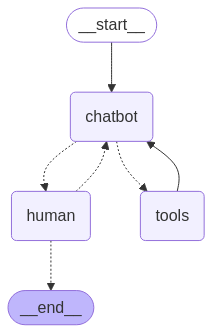

In [9]:
# Adding the tool node
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage


# --- Tool Node ---
tools = [store_jobs]
tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)

## To execute tool node
def maybe_route_to_tools(state: SearchState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        for tool_call in msg.tool_calls:
            if tool_call["name"] == "store_jobs":
                ## storing the jobs in a global variable for later use##
                global job_list
                job_list = []
                job_list.extend(msg.tool_calls[0]['args']['jobs'])
                # print("Storing the list of Jobs", job_list)   # intermediary step to check if the tool is being called    
            
            return "tools"
    else:
        return "human"



def chatbot_with_tools(state: SearchState) -> SearchState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"jobs": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([CAREERCOUNSELLORBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


""" Build the graph and visualise"""
graph_builder = StateGraph(SearchState)
graph_builder.add_node("chatbot", chatbot_with_tools) # Add the nodes, including the new tool_node.
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools) # Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("human", maybe_exit_human_node) # Human may go back to chatbot, or exit.
graph_builder.add_edge("tools", "chatbot") # Tools always route back to chat afterwards.
graph_builder.add_edge(START, "chatbot")
graph_with_jobs = graph_builder.compile()
Image(graph_with_jobs.get_graph().draw_mermaid_png()) # Visualise chat graph

---

### 🚀 Executing the Chatbot with Configurations

To ensure smooth navigation across potentially **longer conversations**, we adjust the recursion limit. The default recursion limit for traversing nodes is **25**, but we can increase it to **100** for more extended interactions. This change allows the chatbot to handle deeper conversations without running into recursion depth errors.

Next, we **execute the graph** to kick off the interaction:
- The chatbot will run indefinitely until the user decides to exit by typing `q`, `quit`, or another exit phrase.
- The system will continue running and processing messages through the defined flow, invoking the appropriate tools and nodes as needed.

This sets the chatbot into motion, ready to engage with the user!

---


In [10]:
config = {"recursion_limit": 100} # default recursion limit for traversing nodes is 25 - setting it higher allows for longer chat
# Loop forever, unless you input `q`, `quit` or one of the other exit terms defined in `human_node`.
state = graph_with_jobs.invoke({"messages": []}, config) # Execute the graph:

Model: Welcome ! I am CarCou your virtual Career Counsellor. I am here to help you unlock your potentials. Are you here today : i) for a job hunt ii)to improve your current prospects eg. salary or change of position ? iii) Please Type `q` to quit.


User:  job hunt


Model: Great! Let's start by getting to know you better.

1.  What is your name?
2.  Type `q` to quit.


User:  Shami


Model: Hello Shami, nice to meet you.

1.  What degrees do you currently hold?
2.  Type `q` to quit.


User:  Master's in nlp engineering


Model: Okay, Shami. An NLP Engineering degree is a great start.

1.  What specific sectors or industries are you most interested in? (e.g., tech, finance, healthcare, etc.)
2.  Type `q` to quit.


User:  healthcare


Model: Alright, Shami. Healthcare is a very important sector.

1.  What is your experience level? Are you a beginner (entering the job market), experienced (looking for a change), or established (looking to further career prospects)?
2.  Type `q` to quit.


User:  beginner


Model: Okay Shami, so just to confirm, you are Shami, you have a Master's in NLP Engineering, you're interested in the healthcare sector, and you're a beginner in the job market. Is that correct?


User:  yes


Model: My apologies, Shami. There seems to be a technical issue with storing the jobs at the moment. However, I can still suggest them to you.

Based on your background, here are three jobs that might be a good fit for you:

1.  NLP Engineer in Healthcare
2.  Data Scientist (Healthcare Focus)
3.  Machine Learning Engineer (Healthcare)

Which of these options is your favourite?

Also, would you like help with a tailored resume?

Type `q` to quit.


User:  NLP Engineer in Healthcare


Model: Great choice, Shami! An NLP Engineer role in healthcare can be very rewarding.

Would you like me to help you create a tailored resume for this position?

Type `q` to quit.


User:  yes


Model: Okay Shami, let's get started on your resume. Based on our conversation, here's a draft. Let me know if you'd like any changes.

```markdown
**Shami**
[Your Phone Number] | [Your Email Address] | [Your LinkedIn Profile (Optional)]

**Summary**

Highly motivated and skilled NLP Engineer with a Master's degree, eager to apply expertise in natural language processing to improve healthcare outcomes. Passionate about leveraging machine learning to solve real-world problems and contribute to a data-driven healthcare environment.

**Education**

*   **Master of Science in NLP Engineering**
    [University Name], [Graduation Year]

**Skills**

*   Natural Language Processing (NLP)
*   Machine Learning
*   Python
*   [Add other relevant skills e.g., TensorFlow, PyTorch, data analysis, etc.]

**Projects**

*   [Project Name]: [Brief description of a relevant NLP project, highlighting your contributions and the results. If you don't have specific healthcare projects, focus on NLP projects 

User:  yes


Model: Okay Shami, to create a cover letter, I need a bit more information. Please provide:

1.  Your surname
2.  Your full address

Type `q` to quit.


User:  1. THIRION SEN 2. CORMEILLES-EN-PARISIS FRANCE 


Model: Okay Shami, thank you for the information. Here is a draft cover letter for you.

```markdown
[Your Full Name (Shami Thirion Sen)]
[Your Address (CORMEILLES-EN-PARISIS FRANCE)]
[Your Email Address]
[Your Phone Number]
[Date]

[Hiring Manager Name (If you know it, otherwise use title)]
[Hiring Manager Title]
[Company Name]
[Company Address]

Dear [Mr./Ms./Mx. Hiring Manager Last Name, or "Hiring Team"],

I am writing to express my keen interest in the NLP Engineer position at [Company Name], as advertised on [Platform where you saw the advertisement]. As a recent graduate with a Master's degree in NLP Engineering and a strong interest in the healthcare sector, I am confident that my skills and passion align perfectly with your requirements.

During my studies, I developed a strong foundation in natural language processing, machine learning, and data analysis. [Mention a specific project or skill that is relevant to the job description and demonstrates your abilities]. I am eager 

User:  QUIT


Model: Thank you for consulting with me today, Shami. I wish you the best in your job search.


User:  q


### 🌐 Search Grounding & Job Query with Grounding

To make **CarCou** even more powerful, we enable **search grounding**, allowing the chatbot to perform real-time internet searches to enhance the responses. With this functionality, the bot can:
- Fetch **recent job postings** based on the user's provided job title and location
- Retrieve **helpful YouTube videos** for job interview preparation

#### 🧠 Job Search Query with Grounding

In the **`job_query_with_grounding()`** function, we enable the chatbot to:
- Ask the user for their **current city** (since geographical location can't be accessed directly in this notebook)
- Search the internet for **5 most recent job postings** matching the job title and location specified by the user

This feature uses **Google Search** to gather relevant information and presents it in a structured JSON format.

**Few-Shot Prompting Idea**:
To improve the performance of this feature, we can use few-shot prompting to guide the model. A few-shot example could look like this:

- **Prompt**: "Find the latest job postings for software engineers in New York. Provide the 5 most relevant postings."
- **Response**: "Here are the top 5 recent job postings for Software Engineers in New York..." (followed by structured details like job titles, companies, and URLs)

This example would help the model understand the format and types of information to retrieve.

---

#### 🎥 Fetching Helpful Videos for Job Preparation

With **`get_links_with_grounding()`**, CarCou can search for **top 5 YouTube videos** that help with job interview preparation for a specific role. For example, if the user is looking for **software engineering jobs**, it will provide the most relevant videos to help them prepare.

The returned output consists of a list of **URLs and brief descriptions** of each video, making it easy for users to explore valuable resources.

**Few-Shot Prompting Idea**:
When asking the model to search for videos, we can guide it with examples to improve results. A few-shot example could be:

- **Prompt**: "Find the 5 most relevant YouTube videos to help someone prepare for a software engineer interview."
- **Response**: "[('https://youtube.com/video1', 'Video 1 description'), ('https://youtube.com/video2', 'Video 2 description'), ...]"

Providing a structure like this helps the model format its output consistently and focus on the most helpful resources.

---

#### 🔍 Extracting Video Links

Once the YouTube video data is retrieved, we use **`parse_video_links()`** to:
- Extract and **format** the video URLs and descriptions from the returned string.
- Present them in an easy-to-read list, so users can quickly access relevant resources.

This step ensures that the chatbot's responses are not only intelligent but **actionable**, providing users with links to videos that can enhance their preparation for their desired roles.

This helps the model understand the correct way to present the extracted data for easy user consumption.

---


In [11]:
from IPython.display import display, Image, Markdown
import re
from urllib.parse import urlparse


# Search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature = 0.0,
)

def job_query_with_grounding(job):
    """
    Gets 5 most jobs posted on the internet based on the job title and the location provided
    """
    # Ideally we should access the geographical location, but we cannot do on this notebook,so we'll ask the user
    country = input("Please the current city where you are looking for a job:")
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="Search the 5 most recent job and their links offers posted on the internet for " + job + "format the answer in a json format located in " + country,
        config=config_with_search,
    )
    return response.text
    

def get_links_with_grounding(job):
    """ Get the  5 most relevant videos that can help with this particual job preparation"""
    response = client.models.generate_content(
        model='gemini-2.0-flash',
       contents='Find the top 5 most relevant YouTube videos to help someone prepare for a job interview' + job + '. Return only a Python list of the video URLs and brief description composing of 5 sentences in a tuple form for each video. For example, if the job is for a software engineer, the output should look like this: [("https://www.youtube.com/watch?v=abcdefg123", video description), ("https://www.youtube.com/watch?v=hijklmn456", video description), ("https://www.youtube.com/watch?v=opqrstu789", video description), ("https://www.youtube.com/watch?v=vwxyz01234", video description), ("https://www.youtube.com/watch?v=uvwxyz56789" , video description)].',            
        config=config_with_search,
    )
    return response.text 



def parse_video_links(video_str : str) -> list[str]:
    """ Extract the video links : ideally generated as a string format containing a python list of links"""
    video_links_and_description = []
    code_block_pattern = r"```python\s*\[(.*?)\]\s*```"
    code_block_match = re.search(code_block_pattern, video_str, re.DOTALL)
    if code_block_match:
        code_content = code_block_match.group(1)
        pattern = r'\("([^"]+)",\s*"([^"]+)"\)'
        matches = re.findall(pattern, code_content)
        for i, (url, description) in enumerate(matches, 1):
            video_links_and_description.append((url,description))
        return video_links_and_description     
    else:
        print("No YouTube links found in code block.")




---
### Retrieval-Augmented Generation (RAG)

#### 🧠 Using Embeddings for **Vector Database with Chroma** (RAG)

In order to create a more **intelligent search experience**, we use **embeddings** to represent documents and queries as high-dimensional vectors. These embeddings are then stored in a **vector database** for fast retrieval based on similarity, enabling the **Retrieval-Augmented Generation (RAG)** method.

#### 🔏 Gemini Embedding Function

We define the **`GeminiEmbeddingFunction`** class, which helps generate embeddings for both documents and queries:
- If we're working with documents, it prepares them for **retrieval** and stores them in the vector database.
- For queries, it allows us to search for the most **relevant document** in the database based on similarity.

The **`@retry` decorator** is used to ensure that when the API quota is hit (e.g., 429 or 503 errors), the request will be retried automatically, ensuring smoother operations.

**RAG (Retrieval-Augmented Generation)**: This approach allows the system to **retrieve** relevant documents (using embeddings) and **augment** the generative model's responses with the retrieved content, making the conversation more informative and contextually relevant.

---

#### 🗂️ Adding Documents to the Vector Database

The function **`add_to_vector_database()`** accepts a list of documents and:
- Generates embeddings for each document.
- Stores these embeddings in the **Chroma vector database**.

This ensures that the documents are represented in a high-dimensional vector space, allowing for fast and efficient similarity-based retrieval later on.

---

#### 🔍 Retrieving Information from the Database

The function **`retrieve_database_item()`** allows us to:
- Generate embeddings for the user’s **query**.
- Search the **Chroma database** to find the most relevant document based on the query.

It retrieves the document ID of the most relevant result, making it easy for the chatbot to return targeted content.

---

With **RAG**, the chatbot combines the **retrieved documents** from the vector database with its **generative capabilities**, improving the relevance and quality of the responses.

---

This setup ensures that **CarCou** can efficiently store, retrieve, and process documents based on semantic similarity, and generate responses that are **contextually enriched** with real-time data from the vector database.

---


In [12]:
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry
from google.genai import types

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503}) # # Define a helper to retry when per-minute quota is reached.


class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004", # model used
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

def add_to_vector_database(documents):
    """And a list of documents list[str] to the vectordatabase"""
    DB_NAME = "googlecardb"
    embed_fn = GeminiEmbeddingFunction()
    embed_fn.document_mode = True # embed mode
    chroma_client = chromadb.Client()
    db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)
    db.add(documents=documents, ids=[str(i) for i in range(len(documents))])

    return db


def retrieve_database_item(query, db):
    """ Retreives the best result corresponding to the user query"""
    embed_fn = GeminiEmbeddingFunction()  # Switch to query mode when generating embeddings.
    embed_fn.document_mode = False
    result = db.query(query_texts=[query], n_results=1) # Search the Chroma DB using the specified query.
    result_id = int(result['ids'][0][0])
    
    return result_id


### 📝 Evaluating AI-Generated Summaries with **LLM as the Judge**

In this section, we evaluate the quality of AI-generated summaries using a **structured evaluation method**. The evaluation checks how well the summary adheres to the task instructions, its groundedness (staying true to the input), conciseness, and fluency. The **LLM** acts as the **judge** to ensure that the generated summaries meet the highest standards. 🤖

#### 🧑‍🏫 Summary Evaluation Process

We define an **evaluation prompt** where the AI (acting as the judge) is tasked with assessing a generated summary according to several **criteria**:

- **Instruction Following**: Does the response adhere to the summarization task’s requirements, including length constraints?
- **Groundedness**: Does the response stay true to the provided context without adding outside information?
- **Conciseness**: Is the summary brief but still informative?
- **Fluency**: Is the response well-structured and easy to read?

#### 🎯 Rating Rubric

- **5**: (Very good) - Excellent adherence to instructions, concise, grounded, and fluent.
- **4**: (Good) - Minor issues, but the response still follows instructions and remains grounded and fluent.
- **3**: (Okay) - Response mostly follows instructions, but lacks conciseness or fluency.
- **2**: (Bad) - Response is grounded but doesn't follow instructions correctly.
- **1**: (Very bad) - The summary is not grounded in the provided context.

---

#### 🛠️ Code Implementation

In the `eval_summary()` function, we evaluate AI-generated responses by:

1. **Creating a chat session**: We use the **Gemini model** (or another available model) to evaluate the quality of the summary, with the LLM acting as the judge in the process.
2. **Constructing the evaluation prompt**: The input prompt and AI-generated response are embedded into a structured evaluation prompt for the LLM to review.
3. **Parsing the Evaluation**: The LLM assesses the summary using the **evaluation rubric**, then returns the evaluation as a structured score (`SummaryRating`).

---

This setup allows for a **detailed, step-by-step evaluation** of AI-generated summaries, providing insights into their quality based on predefined criteria. The LLM's judgment ensures consistency and objectivity in the evaluation process.

---


In [13]:
## Evaluate Video Summary
import enum

# Define the evaluation prompt
SUMMARY_PROMPT = """\
# Instruction
You are an expert evaluator. Your task is to evaluate the quality of the responses generated by AI models.
We will provide you with the user input and an AI-generated responses.
You should first read the user input carefully for analyzing the task, and then evaluate the quality of the responses based on the Criteria provided in the Evaluation section below.
You will assign the response a rating following the Rating Rubric and Evaluation Steps. Give step-by-step explanations for your rating, and only choose ratings from the Rating Rubric.

# Evaluation
## Metric Definition
You will be assessing summarization quality, which measures the overall ability to summarize text. Pay special attention to length constraints, such as in X words or in Y sentences. The instruction for performing a summarization task and the context to be summarized are provided in the user prompt. The response should be shorter than the text in the context. The response should not contain information that is not present in the context.

## Criteria
Instruction following: The response demonstrates a clear understanding of the summarization task instructions, satisfying all of the instruction's requirements.
Groundedness: The response contains information included only in the context. The response does not reference any outside information.
Conciseness: The response summarizes the relevant details in the original text without a significant loss in key information without being too verbose or terse.
Fluency: The response is well-organized and easy to read.

## Rating Rubric
5: (Very good). The summary follows instructions, is grounded, is concise, and fluent.
4: (Good). The summary follows instructions, is grounded, concise, and fluent.
3: (Ok). The summary mostly follows instructions, is grounded, but is not very concise and is not fluent.
2: (Bad). The summary is grounded, but does not follow the instructions.
1: (Very bad). The summary is not grounded.

## Evaluation Steps
STEP 1: Assess the response in aspects of instruction following, groundedness, conciseness, and verbosity according to the criteria.
STEP 2: Score based on the rubric.

# User Inputs and AI-generated Response
## User Inputs

### Prompt
{prompt}

## AI-generated Response
{response}
"""

# Define a structured enum class to capture the result.
class SummaryRating(enum.Enum):
  VERY_GOOD = '5'
  GOOD = '4'
  OK = '3'
  BAD = '2'
  VERY_BAD = '1'


def eval_summary(prompt, ai_response):
  """Evaluate the generated summary against the prompt used."""

  chat = client.chats.create(model='gemini-1.5-flash')

  # Generate the full text response.
  response = chat.send_message(
      message=SUMMARY_PROMPT.format(prompt=prompt, response=ai_response)
  )
  verbose_eval = response.text

  # Coerce into the desired structure.
  structured_output_config = types.GenerateContentConfig(
      response_mime_type="text/x.enum",
      response_schema=SummaryRating,
  )
  response = chat.send_message(
      message="Convert the final score.",
      config=structured_output_config,
  )
  structured_eval = response.parsed.value # number
    
  return verbose_eval, structured_eval




---

### 🎥 YouTube Video Transcription and Summarization

In this section, we focus on extracting the **transcript** from a YouTube video and generating a **concise summary** based on the transcription. The process ensures that summaries are **accurate** and adhere to a **specified length** (500 words, in this case).

#### 🔍 Extracting YouTube Transcription

We begin by extracting the **video ID** from the provided YouTube video URL. This step is important for interfacing with the **YouTube Transcript API** to retrieve the video’s transcript.

1. **Video ID Extraction**: Depending on the URL format (e.g., `youtube.com` or `youtu.be`), the function extracts the video ID.
2. **Transcript Retrieval**: Using the extracted video ID, we call the **YouTube Transcript API** to fetch the transcription of the video.


#### 📝 Video Summary Generation

Once we have the transcript, we generate a concise **summary** using the **Gemini 2.0 Flash model**. This involves submitting the transcript to the model for summarization based on the given prompt.

1. **Prompt Setup**: A custom prompt is constructed by appending the video transcript to the instruction text.
2. **AI Summary Generation**: The model generates a summary of the video transcript.
3. **Evaluation**: The summary is evaluated based on predefined criteria (using the `eval_summary()` function). Only summaries with a rating of **4** or higher are returned; otherwise, the process is repeated.


#### 🛠️ Process Overview

1. **Transcription Extraction**: The video transcript is retrieved from YouTube using its API.
2. **Prompt-Based Summarization**: The model generates a concise summary based on the entire transcript.
3. **Summary Evaluation**: We ensure that only quality summaries (those rated 4 or higher) are kept. In case the summary doesn't meet the quality threshold, the process is retried.

This method enables accurate and reliable summaries of YouTube videos, ensuring that the summaries are **concise**, **relevant**, and **well-structured**.

---



In [14]:
!pip install youtube_transcript_api
from youtube_transcript_api import YouTubeTranscriptApi
from pprint import pprint
from urllib.parse import urlparse, parse_qs


def get_video_transcription(url):
    """Function to extract video ID from a full URL"""    
    parsed_url = urlparse(url)
    if 'youtube' in parsed_url.netloc:
        video_id = parse_qs(parsed_url.query)['v'][0]
    elif 'youtu.be' in parsed_url.netloc:
        video_id = parsed_url.path[1:]
    else:
        video_id = None

    if video_id is not None:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)    
        full_text = ' '.join([entry['text'] for entry in transcript])
    else:
        full_text = None
    return full_text
    
    
# Summarize videos
def get_video_summary(video_url:str, prompt_text="") -> str:
    """
    Takes as input youtube video summary returns it's short summary.

    Args:
    str: Video transcript

    Returns:
    Video summary, as string
    """
    # Get video transcript 
    video_transcript = get_video_transcription(video_url)
    if video_transcript:
        prompt_text = prompt_text + "Please summarize in 500 words the following text in the most natural manner :" + video_transcript    
        response = client.models.generate_content(
            model='gemini-2.0-flash',
            contents=prompt_text,
            config=config_with_search,
        )
        ## Evaluate Response before returning, return only if equal to or above 4 (good or very good)
        verbose_eval, structured_eval = eval_summary(prompt_text, response.text)
        # print("Verbose Eval = ",verbose_eval) # Verbal description of the generation
        print("Structured Eval = " , structured_eval , "\n\n")
        if int(structured_eval) >= 4:
            return response.text
        else:
            # else we're going to regenerate the summary 
            get_video_summary(video_url, "Generate as accurately as possible the following instruction.")
    else:
        return None


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.2 MB/s eta 0:00:0000:0100:01


🎉 **Now that we have all the ingredients, let’s put it all together!** 🎉

In this process, we’re going to guide you through finding the perfect job, preparing for your interview, and helping you succeed at every step. Let’s break it down:

### 1️⃣ **Choose Your Preferred Job** 🧑‍💼  
First, I'll ask you about your **preferred job**. Don’t worry if you’re unsure! You can pick from a list of suggestions, or if you're still not sure, I’ll help you make the best choice. 😌

### 2️⃣ **Get Job Suggestions** 💼  
Once we know your preferred job, I’ll search for **the best job openings** related to that career. You'll get a list of relevant opportunities tailored to your interest. 🎯

### 3️⃣ **Prepare with Helpful Resources** 🎥  
Job found? Great! Now, let’s make sure you're **interview-ready**. I’ll suggest the most relevant **YouTube videos** to help you prepare. 📹 These videos are specially picked to help you shine during interviews!

### 4️⃣ **Select the Best Video & Get a Summary** 🔍  
Got a lot of content? Don’t worry, I’ll help you **pick the best video** for your professional aspirations! 🌟 Once selected, if you need a **summary** to save time, I’ll provide that for you too. 📝

### 5️⃣ **Wrapping It Up** 🎯  
You’ll have control over each step – whether it’s asking for more help or moving on to the next phase. I’m here to assist whenever you need me! 😊

💬 Ready to dive in? Let’s start your journey toward that dream job! 🚀


In [15]:
from IPython.display import Markdown, display
import random, string

try:
    job_list  # Check if it exists
except NameError:
    preferred_job = input("Please enter the job you're interested in: ").strip() # Else get user input
else:
    preferred_job = input("Tell me, amongst " + ", ".join(job_list) + ", which is your favourite job? ").strip()
    if not preferred_job:
        preferred_job = random.choice(job_list)    
    elif preferred_job not in job_list:
        preferred_job = preferred_job.strip().translate(str.maketrans('', '', string.punctuation))
        matches = [job for job in job_list if preferred_job.lower() in job.lower()]
        preferred_job = matches[0]       
print("Thank you, I will find some job suggestions for ", preferred_job, " options.")

try:
    rc = job_query_with_grounding(preferred_job) # get grounded job postings
    print("Here are a few job suggestions based on your interest:")
    display(Markdown(rc))
    assistance = input("Would you like further assistance with your job search? \nI can help you find content online to prepare for your interview. (yes/no): ").strip().lower()
    if assistance in {"yes", "sure", "yup", "why not"}:
        video_links = get_links_with_grounding(preferred_job) # get relevant video links to prepare for the job
        videos = parse_video_links(video_links) # list of all the videos [(video description, video_link)]
        if videos is not None:
            print("Here are a few videos in order to help you prepare.")
            for video in videos:
                print("Video description: ", video[1])
                display(Markdown(f"[Video Link]({video[0]})"))# , video[0], "\n")
            ## vector db
            descriptions = [item[1] for item in videos]
            db = add_to_vector_database(descriptions)
        
            
            # RAG -> pick best -> transcribe and summarize -> evaluate summary
            pick_video = input(print("Wow, that's lot of content! Would you like me to help you further?"))
            if pick_video in {"Sure", "yes", "yeah", "go ahead"}:
                query = input("Ok, describe in a couple of sentences what your professional aspirations are, and I will find a video that's the most suitable for you.") 
            else:
                print("All the very best for your search. Remember CarCou is here for you. See ya!")
                # exit()
            # retrieve the most suitable video 
            best_matching_id = retrieve_database_item(query, db)
            display(Markdown(f"\nAccording to your search the most helpful video is: [Video Link]({videos[best_matching_id][0]})\n, {videos[best_matching_id][1]}"))
            # print("\nAccording to your search the most helpful video is: ", videos[best_matching_id][0], "\n", videos[best_matching_id][1], "\n")
            summarize = (input("Would you like a summary of the video (yes/no)?"))
            if summarize in {"Sure", "yes", "yeah", "go ahead"}:
                video_summary = get_video_summary(videos[best_matching_id][0])
                if video_summary is not None:
                    print("Here is a short summary for you : \n")
                    display(Markdown(video_summary))
                    print("Good luck with your endeavours! Reach out to me anytime. See you!")
                else:
                    print("Sorry, cannot get video transcription right now. My apologies.")
                    exit()
        else:
            print("Sorry, currently I cannot get further links. Please try again later.")            
    else:
        print("Awesome, wish you luck!")
            # exit()

except Exception as e:
    print("Sorry, something went wrong while fetching info:", e)


Tell me, amongst NLP Engineer in Healthcare, Data Scientist (Healthcare Focus), Machine Learning Engineer (Healthcare), which is your favourite job?  Data Scientist (Healthcare Focus)


Thank you, I will find some job suggestions for  Data Scientist (Healthcare Focus)  options.


Please the current city where you are looking for a job: paris


Here are a few job suggestions based on your interest:


```json
[
  {
    "title": "Health Data Scientist",
    "company": "Indeed",
    "location": "Paris (75)",
    "date_posted": "2025-04-19",
    "link": "https://www.indeed.com/jobs?q=Health+Data+Scientist&l=Paris+%2875%29"
  },
  {
    "title": "Senior Data Scientist Deep Learning",
    "company": "Sanofi",
    "location": "Paris (75)",
    "date_posted": "2025-04-16",
    "link": "https://www.indeed.com/jobs?q=Data+Science+Health&l=Paris+%2875%29"
  },
   {
    "title": "Data Scientist",
    "company": "Sanofi",
    "location": "Paris, France",
    "date_posted": "2025-04-09",
    "link": "https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAK-GnbR9g-zY0TCRWf8vKOIZzih4zA6nEISsiXn8MvpPEde3evA3hSIsL_XZ8NF1calsRNLXIsYeuCPO5a_dpeVIQGnYAv3a1626ba1CLHerPFNXEMIN7d6mA2SBEUOPzahI8RbkXjuBMqWKQlZ1MVJP9QwamLpFRu5DTZx5w=="
  },
  {
    "title": "Real-World Evidence Data Scientist",
    "company": "Sanofi",
    "location": "Paris, France",
    "date_posted": "Unknown",
    "link": "https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIzhhlii_Di-178mExTUSC2xGN4fNYx4y1Q7Y_Yzd1MMlP4Fvbm36w99dNUDrs1fKjinwaXjkDegvFjj26OJza55aeFzU0ZPpZgadAJKiytw3GE_X4drHIpcHiRBbCmxKjY6RRyFs3cEfnYL9mB3QDvO3X07j1CB_mK4WV5ZM0FoCt99tbauDr_rl6Xf70Zd0q9SiU="
  },
  {
    "title": "Data Scientist Expérimenté - H/F // Data Lab RH Groupe - BNP Paribas",
    "company": "BNP Paribas",
    "location": "Paris, France",
    "date_posted": "14 hours ago",
    "link": "https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKRRnessCGrkajCfP0cJXEhk11P3t701ClP5WHc7boxVpFtO8k0Up3itQuCiBBgFxunlDmtKf9JYcbNakE8lRtUCt1Ej24Z7E94PXZi89DuqNtEmKSFF092cM6evscXNxHVs9E_9XLPuZCQjCMIWd4j_KIon3L1-puTtwt-Ey4CLw=="
  }
]
```
Please note:

*   The date posted information is relative ("x hours/days ago") and might not be precise.
*   I have included job postings that mention "Data Scientist" and are located in "Paris" or the "Paris area" with a focus on healthcare where possible.
*   Some entries lack a specific date but are included based on relevance and location.
*   The links provided may direct to a search results page rather than a specific job posting in some instances.
*   This information is current as of April 20, 2025.


Would you like further assistance with your job search? 
I can help you find content online to prepare for your interview. (yes/no):  yes


Here are a few videos in order to help you prepare.
Video description:  This video provides six important tips to pass data science interviews. It emphasizes understanding the role and studying the company to align your skills and experiences with their needs. The STAR method (Situation, Task, Action, Result) is recommended for answering questions effectively by providing structured and detailed responses. The video also highlights the importance of being animated and enthusiastic during the interview to demonstrate genuine interest and cultural fit. Additionally, it advises preparing for technical questions by reviewing data science basics and looking for consistent questions asked by the company. Finally, the video suggests planning key examples from your past experiences to showcase your skills and accomplishments.


[Video Link](https://www.youtube.com/watch?v=3zjjEttiHMY&t=199s)

Video description:  This YouTube video presents data science interview questions and answers asked at Cognizant. It emphasizes the importance of being well-prepared for data science interviews to answer questions structurally. The video covers questions related to precision and recall, which are evaluation metrics for classification models in machine learning. It explains how to calculate precision and recall using a confusion matrix with examples related to predicting whether a person has cancer. The video also discusses AB testing, PCA, and multicollinearity, providing detailed explanations and examples for each concept.


[Video Link](https://www.youtube.com/watch?v=DaK-AAXRaIQ?si=5u87thhUuyFKFwrk)

Video description:  This video provides three tips for acing a data scientist interview. First, it emphasizes communicating with the recruiter to understand the interview's scope, including whether it will be a coding, behavioral, product case, or machine learning interview. Second, it advises researching the company to learn about their mission, values, products, services, and culture. This research demonstrates genuine interest and helps answer questions confidently. Third, the video recommends reviewing your resume to present past experiences and projects with ease, ensuring you can answer questions about your roles and responsibilities effectively.


[Video Link](https://www.youtube.com/watch?v=TU0Ce5XQGns?si=xjUhfromZDN_noDV)

Video description:  This video features a full-length data science interview to demonstrate what a data science interview is like. It is useful for those applying for data science or data analytics roles and want to see a strong interview example. The video covers building a dataset for training/testing purposes, feature vectorization, and model implementation details. It suggests pausing after each question to consider how you would answer. The interview includes introductory behavioral questions, a task overview related to a social media platform bot issue, and discussions on feature investigation and classification model implementation.


[Video Link](https://www.youtube.com/watch?v=M5atYaGCFEY?si=Gvr0nSTv60PrCe7w)

Video description:  This video features a conversation with Dr. Adebayo, who shares his journey from medicine to health data science. He discusses the difficulties and benefits of switching from medicine to data science. He emphasizes the importance of understanding the healthcare sector and the ability to interact with various stakeholders. Dr. Adebayo offers helpful guidance for anyone thinking about making the switch to a job in health data science, emphasizing the value of developing a solid foundation in the fundamentals, finding mentors and networking opportunities, and keeping up with the most recent advancements in the industry. He also highlights the high demand for data scientists in the health sector.


[Video Link](https://www.youtube.com/watch?v=2jsPQrjo3XQ?si=gQV_NHPssmoDudSK)

Wow, that's lot of content! Would you like me to help you further?


None yes
Ok, describe in a couple of sentences what your professional aspirations are, and I will find a video that's the most suitable for you. how to prepare for an interview



According to your search the most helpful video is: [Video Link](https://www.youtube.com/watch?v=TU0Ce5XQGns?si=xjUhfromZDN_noDV)
, This video provides three tips for acing a data scientist interview. First, it emphasizes communicating with the recruiter to understand the interview's scope, including whether it will be a coding, behavioral, product case, or machine learning interview. Second, it advises researching the company to learn about their mission, values, products, services, and culture. This research demonstrates genuine interest and helps answer questions confidently. Third, the video recommends reviewing your resume to present past experiences and projects with ease, ensuring you can answer questions about your roles and responsibilities effectively.

Would you like a summary of the video (yes/no)? yes


Structured Eval =  5 


Here is a short summary for you : 



To get shortlisted for data science roles, it's crucial to have a strong portfolio of data science projects on your CV. Here's how to build one:

**1. Take a Focused Approach:**

*   **Experienced Professionals:** If you have industry experience (e.g., finance, automotive), build 2-3 projects related to that domain. Target data science roles within those specific industries.
*   **Freshers:** Focus on popular data science domains like finance, automotive, or manufacturing. Create separate CVs, each highlighting 2-3 relevant projects for each domain.

**2. Project Ideas by Domain:**

*   **Finance:**
    *   Credit card fraud detection.
    *   Credit risk modeling (predicting loan defaults).
    *   Investment banking: Risk prediction using news sentiment analysis to correlate with stock price movements.
*   **Pharma/Healthcare:**
    *   Heart failure risk prediction using health parameters.
    *   Drug discovery clustering: Analyze patient reactions to new drugs using text data to identify symptom patterns.
*   **Automotive/Manufacturing:**
    *   Demand forecasting to optimize supply chain management.
    *   Supply chain delay prediction.
    *   Predictive maintenance: Use IoT sensor data to predict machine maintenance needs.
*   **E-commerce/Telecom:**
    *   Customer churn prediction.
    *   Recommendation models.
    *   Fraudulent transaction prediction.

**3. Project Variety:**

Even within a specific domain, aim for diversity in your project types. Include projects that involve:

*   Classification models.
*   Regression models.
*   Clustering or text data analysis.

**4. Resources:**

Utilize available resources like open-source datasets and domain-specific project implementations to learn and build your projects.

**5. Hands-on Implementation:**

Actively build the projects yourself. This ensures you can confidently answer questions about them during interviews.

By following these steps, you can create a compelling data science project portfolio that significantly increases your chances of landing interview calls.


Good luck with your endeavours! Reach out to me anytime. See you!


## 🎯 Conclusion: Empowering Job Search with AI

This project demonstrates how CarCou integrates real-time search grounding, retrieval-augmented generation (RAG), and few-shot prompting to become a powerful, personalized job assistant. By leveraging these techniques, CarCou is able to provide highly relevant, grounded, and dynamic responses that enhance the user experience. Here's a breakdown of the key takeaways:

### 🌐 Real-Time Information Retrieval
With search grounding, CarCou can fetch the latest job postings and helpful video resources based on the user’s location and job preferences. This makes the chatbot dynamic and context-aware, providing up-to-date and relevant content at all times.

### 🔍 Retrieval-Augmented Generation (RAG)
Using RAG, CarCou intelligently retrieves the most suitable resources by filtering through large amounts of data, ensuring that the responses are accurate and grounded in real-world information. This enables the assistant to provide reliable, actionable responses.

### 🧑‍💼 Grounded Search: Personalized Job Assistance
By asking for the user’s city or job preferences, CarCou delivers personalized **real-time** job listings and resources that match the user’s needs. This personalized approach enhances the relevance of the assistant’s responses, making the experience more engaging and tailored to the individual.

### 🎥 Summarization Capabilities
CarCou goes beyond job listings by fetching relevant YouTube videos to help users prepare for job interviews. It even summarizes videos when needed, through transcription, giving users the right tools to succeed in their job search journey. This holistic approach ensures that users get both job opportunities and interview prep materials.

### 🤖 Few-Shot Prompting for Better Results
With few-shot prompting, CarCou understands the user’s needs more accurately and generates structured, contextually relevant responses. This technique enhances the assistant's ability to interpret user queries and deliver high-quality outputs.

### 📝 LLM as a Judge: Evaluation of AI-Generated Content 
By integrating a structured evaluation mechanism, CarCou ensures that only high-quality content is provided to users. It assesses summaries based on instruction following, groundedness, conciseness, and fluency, ensuring the assistant delivers reliable and trustworthy responses.

### 🚀 Scalability and Flexibility
The system’s architecture is scalable, allowing for the integration of new data sources such as additional job boards, interview prep resources, and more. This flexibility ensures that CarCou can evolve with the changing job market and continue to deliver value over time.

### 💡 Overall Impact
By combining retrieval capabilities, personalization, and evaluation techniques, CarCou provides a comprehensive solution for job seekers. The project showcases the potential for AI to assist users in their career journey by offering relevant, actionable, and dynamic responses. CarCou can be further extended to include additional features like salary insights, company reviews, and career advice, making it a one-stop solution for all job seekers.

In conclusion, this project highlights the power of AI to not only provide information but also offer personalized assistance and valuable insights. CarCou is a next-generation AI assistant, capable of empowering users in their job search journey and helping them succeed in today’s competitive job market. 🌟